In [1]:
# Set the working directory to the parent directory
import sys
sys.path.append('..')
sys.dont_write_bytecode = True

# Import relevant custom libraries
from src.eda import data_info
from src.models import AutoencoderTrainer, AnomalyDetector
from src.evaluation import ValidationEvaluation

# Import relevant libraries
import pandas as pd
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
import numpy as np
import seaborn as sns
import pickle
import tensorflow as tf
import re
import math

# Config
pd.set_option('display.max_columns', None) # Ensure all columns are displayed
warnings.filterwarnings("ignore")

In [2]:
# Read relevant files
X_train = pd.read_feather("../data/processed/X_train.feather")
X_train_validate = pd.read_feather("../data/processed/X_train_validate.feather")

# Get data info
var_info = data_info(X_train)
all_cols = X_train.columns
real_cols = var_info[var_info["var_type"]=="numerical"]["var_name"].tolist()
binary_cols = var_info[var_info["var_type"]=="binary"]["var_name"].tolist()

In [3]:
print("Real-valued variables:", len(real_cols))
print("Binary variables:", len(binary_cols))

Real-valued variables: 9
Binary variables: 55


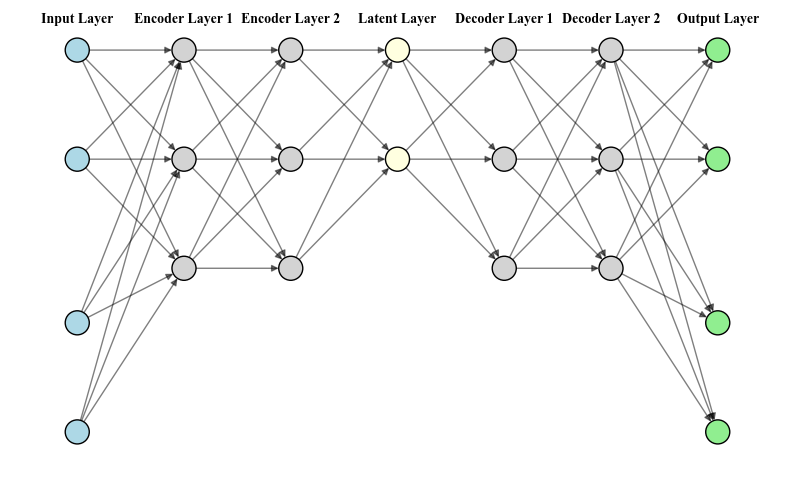

In [4]:
def draw_colored_annotated_autoencoder_graph():
    G = nx.DiGraph()

    # Define layer sizes
    input_real = 2
    input_bin = 2
    encoder_1 = 3
    encoder_2 = 3
    latent = 2
    decoder_1 = 3
    decoder_2 = 3
    output_real = 2
    output_bin = 2

    # Positions for all nodes
    pos = {}
    node_colors = {}

    def place_layer(start_y, n, x, layer_name, color):
        nodes = []
        for i in range(n):
            name = f"{layer_name}_{i}"
            pos[name] = (x, start_y - i)
            nodes.append(name)
            node_colors[name] = color
        return nodes

    # Layers
    input_real_nodes = place_layer(0, input_real, 0, 'in_real', 'lightblue')
    input_bin_nodes = place_layer(-2.5, input_bin, 0, 'in_bin', 'lightblue')
    enc1_nodes = place_layer(0, encoder_1, 1, 'enc1', 'lightgray')
    enc2_nodes = place_layer(0, encoder_2, 2, 'enc2', 'lightgray')
    latent_nodes = place_layer(0, latent, 3, 'z', 'lightyellow')
    dec1_nodes = place_layer(0, decoder_1, 4, 'dec1', 'lightgray')
    dec2_nodes = place_layer(0, decoder_2, 5, 'dec2', 'lightgray')
    out_real_nodes = place_layer(0, output_real, 6, 'out_real', 'lightgreen')
    out_bin_nodes = place_layer(-2.5, output_bin, 6, 'out_bin', 'lightgreen')

    # Add edges
    def connect_all(src, tgt):
        for s in src:
            for t in tgt:
                G.add_edge(s, t)

    connect_all(input_real_nodes + input_bin_nodes, enc1_nodes)
    connect_all(enc1_nodes, enc2_nodes)
    connect_all(enc2_nodes, latent_nodes)
    connect_all(latent_nodes, dec1_nodes)
    connect_all(dec1_nodes, dec2_nodes)
    connect_all(dec2_nodes, out_real_nodes + out_bin_nodes)

    # Prepare node color list
    color_list = [node_colors[n] for n in G.nodes]

    # Draw
    plt.figure(figsize=(10, 6))
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color=color_list, edgecolors='black')
    nx.draw_networkx_edges(G, pos, alpha=0.5)

    # Add layer labels
    layer_labels = {
        0: "Input Layer",
        1: "Encoder Layer 1",
        2: "Encoder Layer 2",
        3: "Latent Layer",
        4: "Decoder Layer 1",
        5: "Decoder Layer 2",
        6: "Output Layer"
    }

    for x, label in layer_labels.items():
        plt.text(x, 0.25, label, horizontalalignment='center', fontsize=10, fontweight='bold')

    # Add activation/loss labels near output
    #plt.text(6.2, -0.5, "Linear + MSE", fontsize=8, color='darkgreen')
    #plt.text(6.2, -3.1, "Sigmoid +\nCross-Entropy", fontsize=8, color='darkred')

    # Add activation/loss labels near output
    #plt.text(-0.7, -0.6, "Real-Valued\nInput", fontsize=8, color='darkblue')
    #plt.text(-0.7, -3.0, "Binary Input", fontsize=8, color='red')

    plt.axis('off')
    plt.savefig("../results/figures/autoencoder_graph.png", bbox_inches='tight', dpi=300)
    plt.show()

draw_colored_annotated_autoencoder_graph()

## 1. Test the trainer

In [5]:
"""ae = AutoencoderTrainer(
    input_dim=X_train.shape[1],
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    hidden_dims=(64,),
    learning_rate=0.02,
    dropout_rate=0.35238800530161296,
    lam=1e-4,
    gamma=0.999,
    batch_size=64,
    verbose=True,
    max_epochs=500,
    plot_losses=True
)
#Best parameters: {'hidden_dims': (64,)
# , 'batch_size': 64
# , 'dropout_rate': 0.35238800530161296
# , 'learning_rate': 0.02
# , 'lam': 0.0001
# , 'gamma': 0.999
# , 'threshold': 0.039907783269882195}

autoencoder = ae.train(X_train, X_train_validate)"""

"ae = AutoencoderTrainer(\n    input_dim=X_train.shape[1],\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    hidden_dims=(64,),\n    learning_rate=0.02,\n    dropout_rate=0.35238800530161296,\n    lam=1e-4,\n    gamma=0.999,\n    batch_size=64,\n    verbose=True,\n    max_epochs=500,\n    plot_losses=True\n)\n#Best parameters: {'hidden_dims': (64,)\n# , 'batch_size': 64\n# , 'dropout_rate': 0.35238800530161296\n# , 'learning_rate': 0.02\n# , 'lam': 0.0001\n# , 'gamma': 0.999\n# , 'threshold': 0.039907783269882195}\n\nautoencoder = ae.train(X_train, X_train_validate)"

## 2. Test the anomaly detector

In [6]:
"""# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# After training
detector = AnomalyDetector(
    model=autoencoder,
    real_cols=real_cols,
    binary_cols=binary_cols,
    all_cols=all_cols,
    lam=0.0001,
    gamma=0.999,
)

# Compute scores
scores = detector._compute_anomaly_scores(X_validate)

# Detect
y_pred = detector._detect(scores, 0.039907783269882195)

# Evaluate
metrics = detector._evaluate(y_pred, y_validate, scores)
print(metrics)"""

'# Read relevant files\nX_validate = pd.read_feather("../data/processed/X_validate.feather")\ny_validate = pd.read_feather("../data/processed/y_validate.feather")\n\n# After training\ndetector = AnomalyDetector(\n    model=autoencoder,\n    real_cols=real_cols,\n    binary_cols=binary_cols,\n    all_cols=all_cols,\n    lam=0.0001,\n    gamma=0.999,\n)\n\n# Compute scores\nscores = detector._compute_anomaly_scores(X_validate)\n\n# Detect\ny_pred = detector._detect(scores, 0.039907783269882195)\n\n# Evaluate\nmetrics = detector._evaluate(y_pred, y_validate, scores)\nprint(metrics)'

## 3. Hyperparameter Tuning

### 3.1. Tuning Implementation

In [7]:
#! cd ..; python3.11 "scripts/baseline_model.py" --metric auc --n_calls=30 --version 202504131912
#! cd ..; python3.11 "scripts/baseline_model.py" --metric f1_score --n_calls=30 --version 202504130119
#! cd ..; python3.11 "scripts/baseline_model.py" --metric precision --n_calls=30 --version 202504130111
#! cd ..; python3.11 "scripts/baseline_model.py" --metric recall --n_calls=30 --version 202504131715

### 3.2. Summarize the Performance on Validation Set

In [8]:
# Read relevant files
X_validate = pd.read_feather("../data/processed/X_validate.feather")
y_validate = pd.read_feather("../data/processed/y_validate.feather")

# Initialize the validation evaluation
valeval = ValidationEvaluation(X_validate, y_validate, real_cols, binary_cols, all_cols, dp_sgd=False)
    
# Read the log file
log_path = "../logs/baseline_tune_log.txt"

# Extract the latest successful Bayesian versions
latest_successful_versions = valeval.extract_latest_successful_bayesian_versions(log_path)
print(latest_successful_versions)

# Evaluate the model performance
eval_results = valeval.evaluate_model_performance(latest_successful_versions)
display(eval_results)

{'202505080012': ('AUC', datetime.datetime(2025, 5, 13, 3, 21, 57, 186961)), '202505080154': ('Precision', datetime.datetime(2025, 5, 8, 2, 50, 26, 588021)), '202505112013': ('F1-Score', datetime.datetime(2025, 5, 13, 3, 5, 23, 711939)), '202505080250': ('Recall', datetime.datetime(2025, 5, 13, 2, 41, 53, 651435))}
Evaluating version 202505080012
Metric: AUC
Evaluating version 202505080154
Metric: Precision
Evaluating version 202505112013
Metric: F1-Score
Evaluating version 202505080250
Metric: Recall


,precision,recall,f1_score,auc,accuracy,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,threshold,tuned_by,end_time
version,,,,,,,,,,,,,,
202505080154,0.781850,0.194360,0.311327,0.707686,0.827005,"(64,)",79.0,0.308206,0.042715,0.031488,0.212212,14.037385,Precision,2025-05-08 02:50:26.588021
202505080250,0.483270,0.720607,0.578544,0.851407,0.788775,[64],110.0,0.210764,0.060430,0.001106,0.999000,0.033476,Recall,2025-05-13 02:41:53.651435
202505112013,0.576626,0.680694,0.624353,0.876336,0.835210,[64],83.0,0.000000,0.090339,0.002620,0.999000,0.041201,F1-Score,2025-05-13 03:05:23.711939
202505080012,0.585447,0.691106,0.633904,0.883887,0.839399,"[64, 32]",83.0,0.000795,0.088987,0.001651,0.999000,0.046916,AUC,2025-05-13 03:21:57.186961


In [9]:
display(eval_results)

,precision,recall,f1_score,auc,accuracy,hidden_dims,batch_size,dropout_rate,learning_rate,lam,gamma,threshold,tuned_by,end_time
version,,,,,,,,,,,,,,
202505080154,0.781850,0.194360,0.311327,0.707686,0.827005,"(64,)",79.0,0.308206,0.042715,0.031488,0.212212,14.037385,Precision,2025-05-08 02:50:26.588021
202505080250,0.483270,0.720607,0.578544,0.851407,0.788775,[64],110.0,0.210764,0.060430,0.001106,0.999000,0.033476,Recall,2025-05-13 02:41:53.651435
202505112013,0.576626,0.680694,0.624353,0.876336,0.835210,[64],83.0,0.000000,0.090339,0.002620,0.999000,0.041201,F1-Score,2025-05-13 03:05:23.711939
202505080012,0.585447,0.691106,0.633904,0.883887,0.839399,"[64, 32]",83.0,0.000795,0.088987,0.001651,0.999000,0.046916,AUC,2025-05-13 03:21:57.186961


In [10]:
eval_results.to_csv("../experiments/perf_summary/baseline_val_results.csv")

### 3.3. Compare Models Based on Validation Set

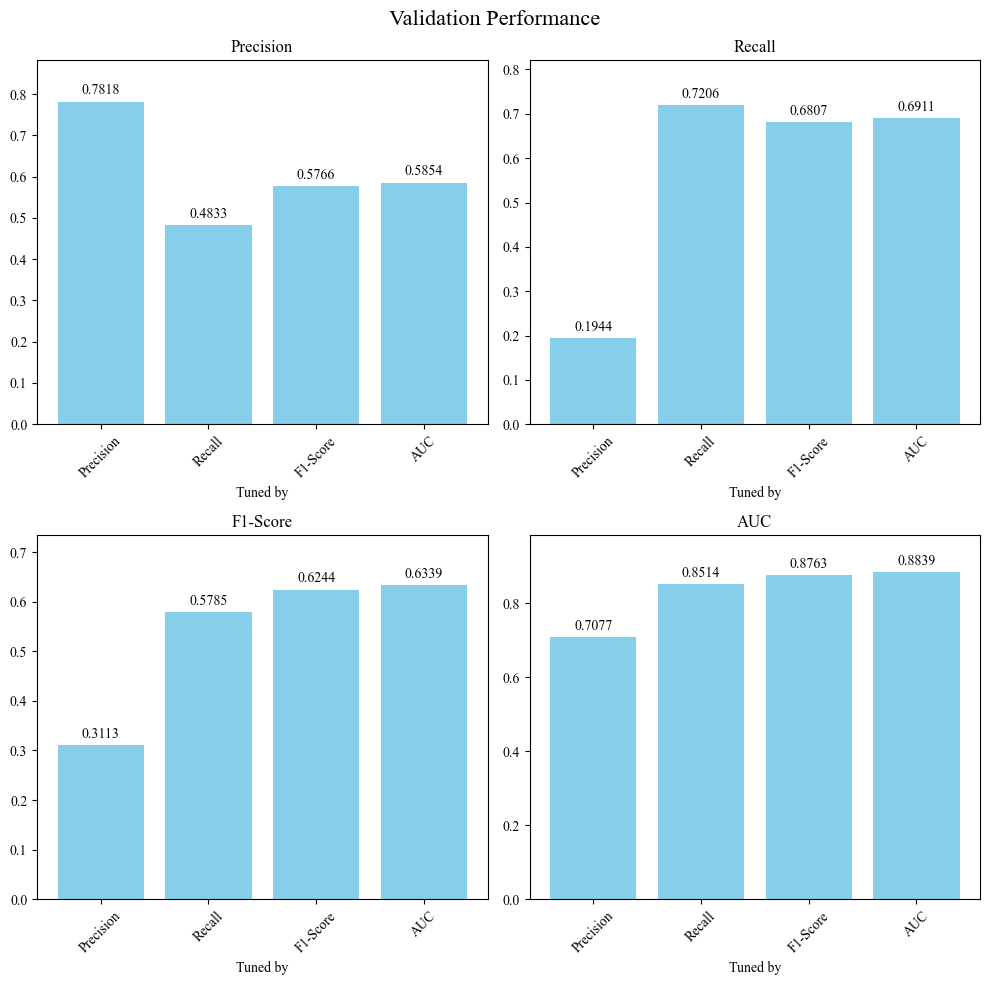

In [11]:
##################################################
## Plot a barplot of the validation performance ##
##################################################

valeval.plot_bar(eval_results, save=False)

### 3.4. Inspect Convergence of Bayesian Optimization

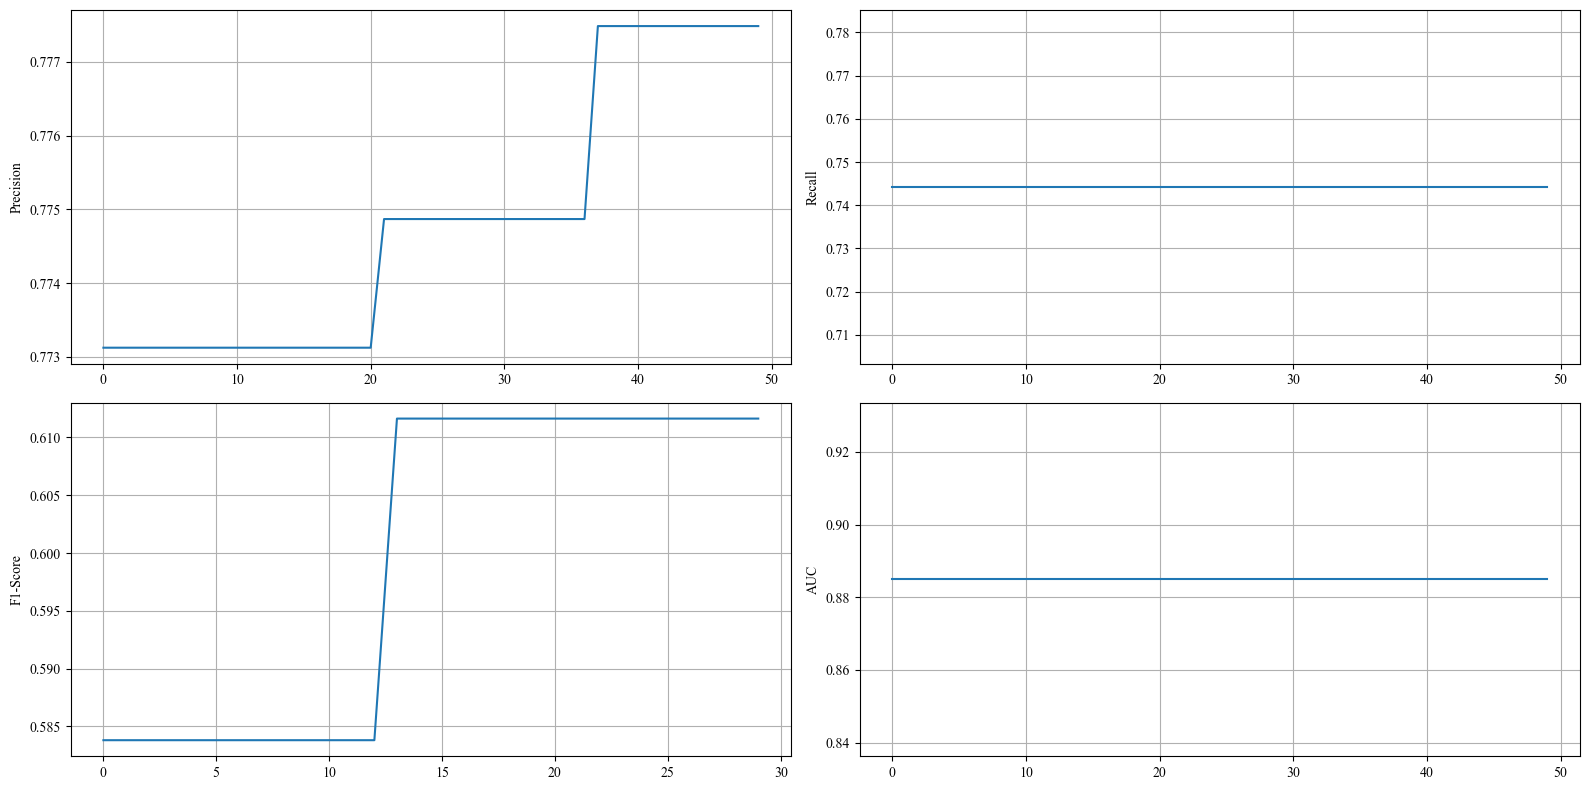

In [12]:
### 3.4. Compare Models Based on Validation Set

# Sort and reset index for consistent iteration
sorted_results = eval_results.reset_index()

# Set up grid
n_cols = 2
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax = axes[i]
    metric = row["tuned_by"].lower().replace("-", "_")
    version = row["version"]

    # Read result file
    results_df = pd.read_csv(f"../experiments/hyperparam_tune/baseline/bayes_{metric}_{version}.csv")
    results_df["best_so_far"] = results_df[metric].cummax()

    # Plot
    ax.plot(results_df.index, results_df["best_so_far"])
    ax.set_ylabel(row["tuned_by"])
    ax.grid(True)

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 3.5. Check Convergence of the Final Training

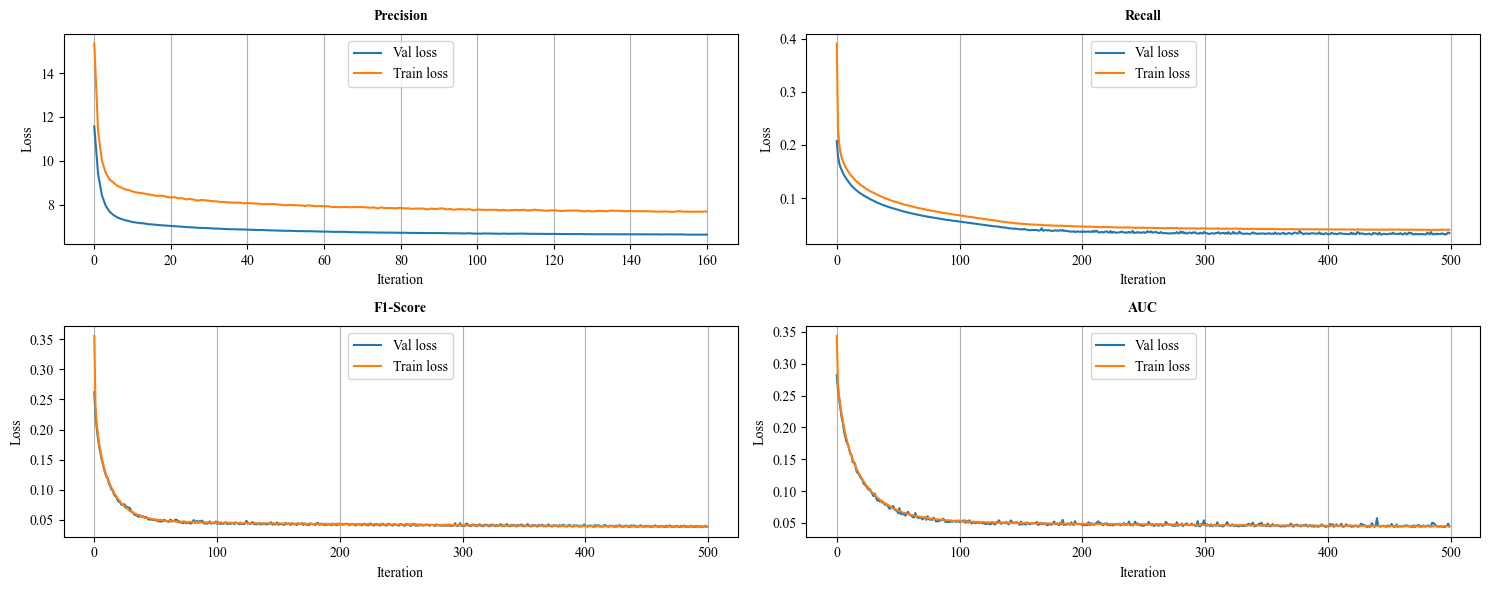

In [13]:
import os
import glob

# Sort and reset index for consistent iteration
sorted_results = eval_results.reset_index()

# Set up grid
n_cols = 2
n_rows = math.ceil(len(sorted_results) / n_cols)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 3 * n_rows))
axes = axes.flatten()

# Track previous epsilon for row titles
row_epsilons = []

for i, row in sorted_results.iterrows():
    ax1 = axes[i]
    # Create second y-axis sharing the same x-axis
    version = row["version"]
    metric = row["tuned_by"]

    # Read result file
    folder = "../experiments/tracking"

    # Read the existing files with the same version prefix
    pattern = os.path.join(folder, f"{version}_*.csv")
    for file in glob.glob(pattern):
        results_df = pd.read_csv(file)

    # Plot loss on the left y-axis
    ax1.plot(results_df.index, results_df["val_loss"], label='Val loss')
    ax1.plot(results_df.index, results_df["train_loss"], label='Train loss')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper center')

    # Set grid for x-axis
    ax1.grid(True, axis='x')

    # Set a title specific to each subplot
    ax1.set_title(f"{metric}", fontsize=10, pad=10, fontweight='bold')

# Hide unused subplots if total is not a multiple of n_cols
for j in range(len(sorted_results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()